In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 10: Support Vector Machines

----
### Section 0: Project

**Question 0.1** Describe what you did to assist your group this week. Also describe your understanding of what each of your teammates did this week. Please make sure to discuss with them if you are at all unsure of what your teammates did. It's ok if some people do more than others from one week to the next, but you should make sure that everyone's pulling weight over the semester.

*YOUR ANSWER HERE*

----

This homework will use support vector machines to classify CalEnviroScreen data. We will take gradual steps in this homework, starting from recalling key information from lectures and textbook, to creating our own classifiers. Throughout the homework, we'll learn about the intuition behind the Perceptrons and Maximal Margin Classifiers (MMC), then move on to learning about the intuition behind support vector machines (SVMs) and applying them to CalEnviroScreen data. The textbook reference here is ISLR 9.1-9.3.


### Table of Contents

1. [CalEnviroScreen Data](#data)<br>
1. [Perceptrons and MMC](#perceptron)<br>
1. [SVM Intuition](#svm)<br>
1. [Using SVM to Classify CalEnviroScreen Data](#classify) <br>

**Dependencies:**

In [2]:
# Import Packages
import numpy as np
import pandas as pd
from matplotlib import style
from matplotlib import pyplot as plt

# Import Samples Generator
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Color Scheme for SVM!
colormap = np.array(['blue', 'gold']) # Go bears!

# Allows us to plot SVC decision functions
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC
    
    Variables: 
        model: classifier
    
    Usage:
    >>> from sklearn.svm import SVC
    >>> clf = SVC(kernel='linear')
    >>> clf.fit(X, y)
    >>> plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    >>> plot_svc_decision_function(clf) # Draw the decision boundary
    >>> plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');
    """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

---

### CalEnviroScreen Dataset <a id='data'></a>
Carrying on from the previous homework, we will continue to use the CalEnviroScreen dataset. CalEnviroScreen 4.0 is a comprehensive documentation of the environmental and the demographic conditions of each census tract in California. 

Please note that the Excel file can be downloaded from [here](https://oehha.ca.gov/calenviroscreen/report/draft-calenviroscreen-40). However, for this homework, the Excel file has already been placed in the same directory as the homework. 

Before we get to working with the data, however, we're going to use simulated data to develop some concepts.

---
### Section 1: Perceptrons and Maximal Margin Classification  <a id='perceptron'></a>

#### What's a Perceptron?

If that question scares you, please go back to review the lecture slides from Duncan's lecture 20 "SVM handout" on bCourses. 

SVMs are a way to classify observations into one of two possible classes. SVMs are a pretty flexible method that can allow for non-linear splits between observations. Given a set of hyperparameters, the SVM delivers a unique solution. 

For the purposes of this homework, a perceptron is any hyperplane sitting between linearly separable data. In this way perceptrons are a little more generic than SVMs (any plane will do) and a little less flexible (the data need to be linearly separable).  

We use the following mathematical notation when we talk about perceptrons. We'll define our training dataset as $D$, and the number of points in $D$ as $n$, with the following notation:

$D = \{(x_i, y_i)\}_{i = 1}^{n}$

$x_i$ and $y_i$ have to meet certain criteria: $y_i$ can only be equal to -1 or 1, where -1 represents one class and 1 represents another class. This is expressed mathematically as:

$y_i \in \{-1 , +1\}$

We also specify that $x_i$ has to be a real number (this is not a condition that we really have to worry about in our applications of machine learning) in this way:

$x_i \in R^p$ 

$p$ is the number of features we have - i.e. $X$ is a $n \times p$ matrix.

A perceptron is a $p - 1$-dimensional hyperplane that perfectly separates $+1$ and $-1$. A hyperplane is defined as a "flat subspace of a $p$-dimensional space." 

Let's think about what this means intuitively, by considering different values of $p$. If $p = 1$, that means we're trying to divide a single set of predictors into two categories. In this case, a $(p - 1)$-dimensonal hyperplane is a 0-dimensional hyperplane - which in our case is just a single point! You can think of your $x$ values as falling along a number line, and your division being a single point on that line. If $p = 2$, we're dividing two sets of predictors into two categories, so we want a 1-dimensional hyperplane - this is a line. In this case, you can think of plotting your first predictor $x_1$ on an x-axis, and $x_2$ on a y-axis; a line can be drawn to separate observations.

**Question 1.1 (2pts)** If we have 3 predictors, what is the shape and dimension of a hyperplane that divides our observations into two classes? How would you plot this hyperplane?

*Your answer here*

**Answer** *The hyperplane will be a plane in 2-dimensions. You would plot it on a 3-dimensional plot, with x, y, and z axes.*

In the next question, we are going to use `make_blobs` and `make_circles` extensively. These are sample generators made by `scikit-learn` package, which--as their names imply--will allow us to randomly generate blobs and circles of data.

The following cell is an example of how we might call `make_blobs`, and what the results look like.

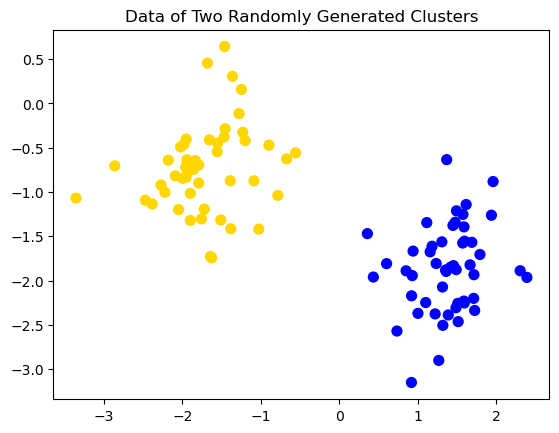

In [3]:
# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=100, centers=2, cluster_std=0.50, center_box=(-2, 2), random_state = 2100)

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)

**Question 1.2 (1pts):** There are many hyperplanes that can separate these two clusters of data. Give 3 possible examples in the code below based on visually inspecting the plot above. We've started defining three tuples for you (`first`, `second`, and `third`), where the first item in each tuple is the slope and second item should be the y-intercept. In other words, `first/second/third = (slope, y-intercept)`. The first example has been done for you. The cell below will take your slope and intercept and plot them. 

(*Side note:* We talked about tuples at the start of the semester -- but here's a reminder: They're kind of like lists, in that they contain a sequence of values through which you can iterate, but unlike lists the values they contain can't be modified easily after they're initialized. Tuples are contained in round brackets (`()`) while lists are contained in square brackets (`[]`)).

In [4]:
# Define example hyperplanes here
first = (1.5, -1)
second = (..., ...)
third = (..., ...)

In [5]:
# SOLUTION
# ANY REASONABLE SOLUTION based on the plots in the next cell. 
# example solution
first = (1.5,-1)
second = (0.6,-1.3) # -1 = 5*-1 + b
third = (4,-1.5) # -1.5 = 1*-0.5

Run the following cell to double-check that your answers are right and reasonable.

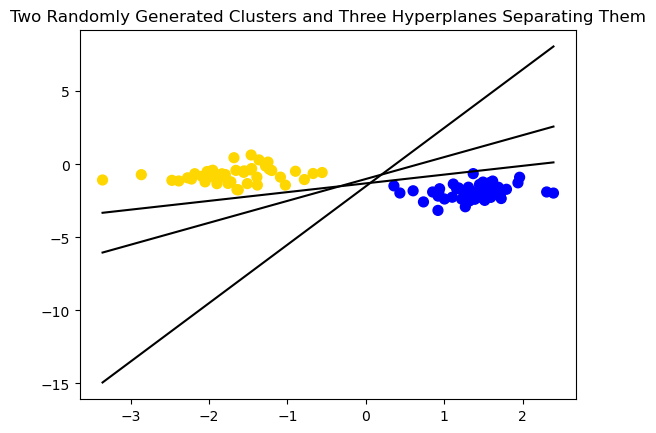

In [6]:
# Plotting 
xfit = np.linspace(X[:,0].min(), X[:,0].max())
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)

for m, c in [first, second, third]:
    plt.plot(xfit, m * xfit + c, '-k')

plt.title("Two Randomly Generated Clusters and Three Hyperplanes Separating Them");

<b> Question 1.3 (1pt): </b> There are multiple answers (we definitely know there are at least 3!) to Question 1.2. Explain why. 

*Your answer here*

**Answer** *If our data can be perfectly separated using a hyperplane, then there will in fact exist an infinite number of such hyperplanes. A given separating hyperplane can be shifted a little up or down, or rotated, without coming into contact with any of the observations*

**Question 1.4 (1pt):** The issue explored above - i.e., that a dataset can allow for multiple hyperplanes that divide it - lead us to use maximal marginal classification (MMC) or hard-margin SVM in practice. In a few sentences, explain what differentiates MMC from the perceptrons that we've explored above.

*Your answer here*

**Answer** *In order to construct a classifier based upon a separating hyperplane, we must have a reasonable way to decide which of the infinite possible separating hyperplanes to use. Hard-margin SVM is a natural choice that chooses the hyper-plane farthest from the training observations. This gives more room and accuracy when we test.*

---
### Section 2: SVM Intuition <a id='svm'></a>

Before we start classifying the CalEnviroScreen Dataset, let's review the intuition behind using Support Vector Machines. 

<img src="svd.png" width="400">

This is an example of an artificially created data-set to be classified, where red $+$ data points and green $\large{\circ}$ data points represent two different classes. In the following questions, assume the following: 
1. Training data comes from extremely accurate sensors, so we are pretty confident about the location of any one point,
2. We are training our SVM using a __quadratic__ kernel. The hyperparameter $C$ will determine the location of the separating hyperplane.

Answer the following questions with a one line justification.

**Question 2.1 (1pt)** Given the potential decision boundaries below, which one has a large $C$ (i.e. $C \to \infty$) and which one has a small $C$ (i.e. $C \to 0$)?

<img src="svd2.png" width="400">

*Your answer here*

**Answer** *Left will have small C, right will have a large C*

**Question 2.2 (1pt)** In this particular dataset, why might it be more advantageous to use a small value of $C$ than a large one?

*Your answer here*

**Answer** *It is more advantageous to use a small $C$ since we are asked to assume that we should trust our data, so we prefer $C \to 0$ because it separates our data into two classes.*

**Question 2.3 (1pt)** Imagine you've received one additional data point in the red + class. Name one coordinate this data point could have that will **not change** the decision boundary for small values of C. Justify your answer.

*Your answer here*

**Answer** *Any reasonable answer, for example addition of Red $(2, 2)$. The reason is that this point will not become a new support vector; it fits in very nicely with the currently trained model*

**Question 2.4 (1pt)** Name one coordinate the new data point could have that **will** change the decision boundary learned for small values of $C$. Justify your answer.

*Your answer here*

**Answer** *Any reasonable answer, for example, addition of Red $(7, 8)$, w because it will become a new support vector.*

Before we begin the next set of questions, run the following cell to import the module we need to run SVM using `scikit-learn`. 

In [7]:
from sklearn.svm import SVC

In this question, we are going to use `make_blobs` again. Run the cell below to generate another set of random blobs.

Keep this code in mind as you will later be asked to call `make_circles`. 

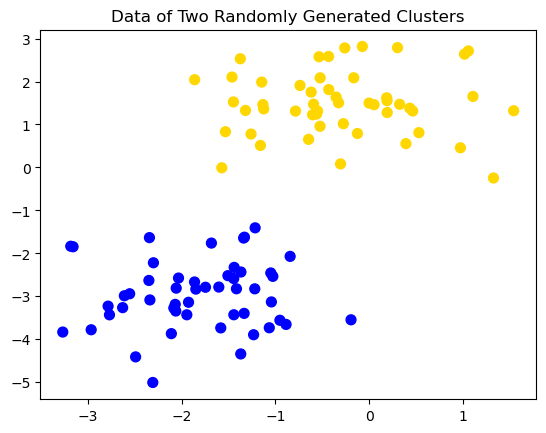

In [8]:
# Generating blobs of data with 2 centers
X, y = make_blobs(n_samples=100, centers=2, cluster_std=0.8, center_box=(-3, 3), random_state = 11)

# Plotting the blobs of data
plt.title("Data of Two Randomly Generated Clusters")
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)

Let's now use support vector machines to classify our data. 

**Question 2.5 (1pt)** Instantiate a Support Vector Machine Classifier in the following cell with a `linear` kernel and `C`=1.

*Hint:* Use `SVC` to create your model and refer to this [link](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for more information. **Important note:** Look at the scikit learn documentation to see the definition of the parameter `C` as applied in scikit-learn! It's not quite the same as the hyperparameter $C$. 

Then, fit your support vector machine on the data. Remember, the features for the blobs are in `X` and labels are `y`.

In [11]:
# Replace perentheses with your answers
clf = SVC(kernel = ..., C=1.0)
clf.fit(...)

TypeError: fit() missing 1 required positional argument: 'y'

In [10]:
# SOLUTION
clf = SVC(kernel='linear',C=1.0)
clf.fit(X,y)

SVC(kernel='linear')

Now, let's have a look at what we have made by running the following cell, which calls the function `plot_svc_decision_function()`.

Text(0.5, 1.0, 'SVM on the Blobs of Data')

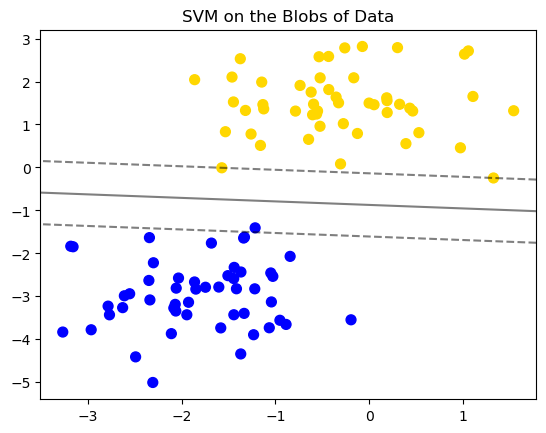

In [11]:
# Graphing SVM and Data
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)

plt.title("SVM on the Blobs of Data")

**Question 2.6 (2pts)** Repeat the process of fitting the SVC, but this time specify three different values for the parameter `C` in the `SVC` function: a low value (C<1), a medium value (1<=C<=10), and a high value (C>10). Specify your three values for C as a list called `C_values`. Run the code block to graph the three decision boundaries that result.

Explain what happens as we increase our value of the `C` parameter.

TypeError: must be real number, not ellipsis

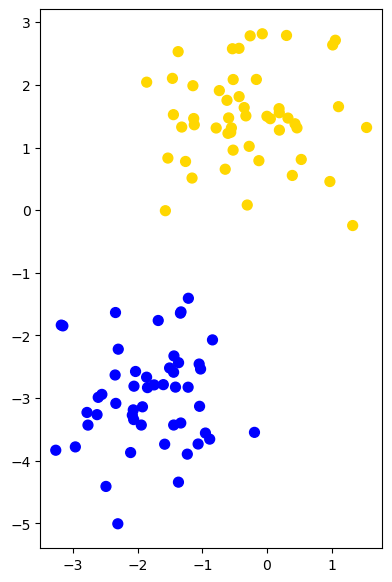

In [12]:
C_values = [...] # YOUR CODE HERE

plt.figure(figsize=(15,7))
for i in range(len(C_values)):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
    model = SVC(kernel='linear',C=C_values[i])
    model.fit(X,y)
    plot_svc_decision_function(model)
    plt.title('C = {}'.format(C_values[i]))

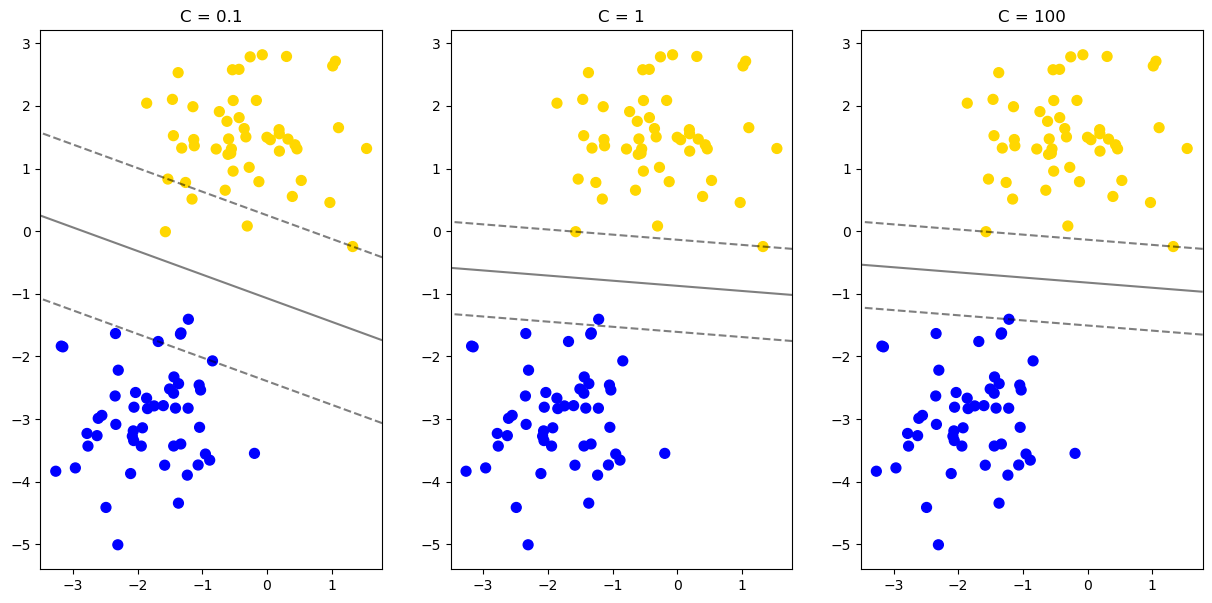

In [13]:
# SOLUTION
C_values = [0.1,1,100]

plt.figure(figsize=(15,7))
for i in range(len(C_values)):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
    model = SVC(kernel='linear',C=C_values[i])
    model.fit(X,y)
    plot_svc_decision_function(model)
    plt.title('C = {}'.format(C_values[i]))

*YOUR ANSWER HERE*

*SOLUTION* *At very low values of `C`, we see more "violations" to our margin. Thus, the model with low `C` will have more bias and less variance than a model with high `C`. It's important to note that the parameter `C` in the scikit-learn function is defined as the* ***inverse*** *of the hyperparameter C we discussed in Question 2.1, so the relationship between a large and small C is reversed.*

So far, we have only really dealt with linearly separable data. What happens if the data is not linearly separable? Let's examine these cases in the following questions. 

Just as we have created our dataset for blobs of data, we'll now make a new dataset for circles below and plot that data, using different colors for the different classes of data.

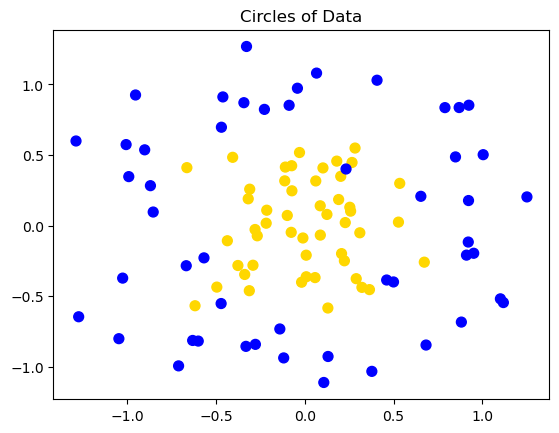

In [14]:
X, y = make_circles(100, factor=.3, noise=.2)

# Graphing data points
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plt.title("Circles of Data")
plt.show()

**Question 2.7 (1pt)**: Train this new dataset using a linear kernel and `C`=1.0. Plot the points along with the decision boundary, using the function `plot_svc_decision_function()`. Feel free to take a similar approach to that of the previous code blocks. 

In [17]:
# YOUR CODE HERE
clf = SVC(...) # any value of c works as long as it is low!
clf.fit(...)

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM (Linear) on Circles of Data")
plt.show()

TypeError: __init__() takes 1 positional argument but 2 were given

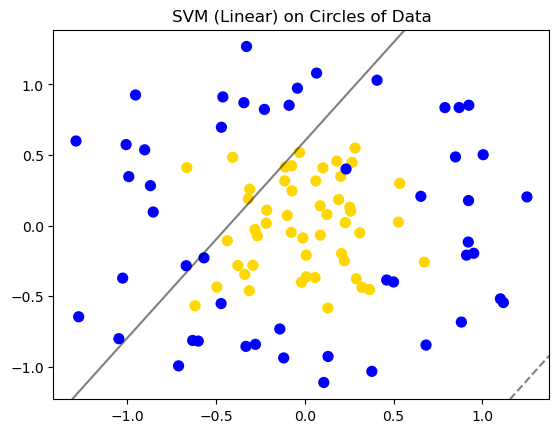

In [15]:
clf = SVC(kernel='linear', C=1) # any value of c works as long as it is low!
clf.fit(X, y)

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM (Linear) on Circles of Data")
plt.show()

The linear kernel doesn't really do a good job of distinguishing these two classes. Let's try a radial basis kernel, called `"rbf"` in scikit-learn. 

**Question 2.8 (1pt)** Repeat the steps in Question 2.8, but with a radial basis kernel. Try out a few different values for `C` and include your favorite in your homework submission.

In [20]:
# YOUR CODE HERE
clf = SVC(...)
clf.fit(...)

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM on Circles of Data")
plt.show()

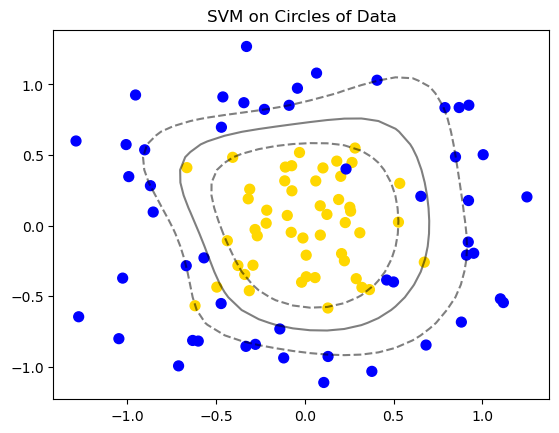

In [16]:
# SOLUTION 
clf = SVC(kernel='rbf', C=10)
clf.fit(X, y)

# Graphing decision boundaries
plt.scatter(X[:, 0], X[:, 1], c=colormap[y], s=50)
plot_svc_decision_function(clf)
plt.title("SVM on Circles of Data")
plt.show()

---
### Section 3: Using SVM to Classify CalEnviroScreen Data <a id='classify'></a>

<br>
Now that we've explored how SVM works and how to implement it, let's begin applying our knowledge on the CalEnviroScreen dataset.

In [17]:
# run this cell to import CES 4.0 draft results
ces4 = pd.read_excel('CalEnviroScreen_4.0Excel_ADA_D1_2021.xlsx',sheet_name=0,header=0)
ces4.head()

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2760,Fresno,93706,Fresno,-119.781696,36.709695,94.608491,100.000000,95-100% (highest scores),...,83.108379,76.6,98.429648,16.2,97.151695,30.7,90.614723,93.732898,9.718389,99.873897
1,6077000700,4177,San Joaquin,95206,Stockton,-121.287873,37.943173,90.831885,99.987390,95-100% (highest scores),...,96.338367,70.6,96.432161,18.5,98.453409,35.2,95.610928,93.402818,9.684166,99.836066
2,6077000100,4055,San Joaquin,95202,Stockton,-121.285363,37.953996,85.750324,99.974779,95-100% (highest scores),...,88.774556,81.8,99.497487,17.9,98.169867,36.4,96.508981,95.708085,9.923180,99.974779
3,6071001600,5527,San Bernardino,91761,Ontario,-117.618013,34.057780,83.556404,99.962169,95-100% (highest scores),...,97.113457,67.1,94.824121,6.7,57.198093,32.1,92.651151,80.589322,8.355640,93.064313
4,6037204920,2639,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.895832,99.949559,95-100% (highest scores),...,88.440465,64.9,93.505025,5.6,43.807192,25.0,77.953453,83.954388,8.704536,95.775536


**Question 3.1 (1pt)** Before we get started, we'll select only the data we want to include in our model. We'll choose two predictors: `Poverty Pctl` and `Education Pctl`. Based on these predictors, we will try to predict whether a census tract falls in the highest (90-100%) or lowest (1-10%) percentiles of the `Pollution Burden Pctl` column of the CES4.0 scores. We also need to remove any records with null feature values from our dataframe, or else our SVM classification algorithm will throw errors.  In the cell below, create the `X` and `y` dataframes.

In [23]:
# Subset the ces4 dataframe to include only records with Pollution Burden Pctl 
# values that are > 90 and < 10. 
pct_10_90 = ces4[(...) | (...)]

# Remove all rows of pct_10_90 with null values.
pct_10_90 = ...

# The X dataframe should include two variables: Poverty Pctl and Education Pctl.
X = pct_10_90[[...]]

# Construct a response variable y from the Pollution Burden Pctl feature in pct_10_90. 
# If Pollution Burden Pctl is high y should be True, if it's low y should be False.  
y = pct_10_90[[...]]>50

TypeError: unsupported operand type(s) for |: 'ellipsis' and 'ellipsis'

In [18]:
# SOLUTION

# Subset the ces4 dataframe to include only records with Pollution Burden Pctl values that are > 90 and < 10. 
pct_10_90 = ces4[(ces4['Pollution Burden Pctl'] > 90) | (ces4['Pollution Burden Pctl'] <10)]

# Remove all rows of pct_10_90 with null values
pct_10_90 = pct_10_90.dropna()

# The X dataframe should include two variables: Poverty Pctl and Education Pctl
X = pct_10_90[['Poverty Pctl','Education Pctl']]
# X = pct_10_90[['Housing Burden','PM2.5']]

# Construct a response variable y from the Pollution Burden Pctl feature in pct_10_90. 
# If Pollution Burden Pctl is high y should be True, if it's low y should be False.  
y = pct_10_90[['Pollution Burden Pctl']]>50

In [19]:
# Check that your X has the correct number of rows and columns
assert X.shape == (1461,2)

# Check that your y has only two classes
assert len(y.iloc[:,0].unique())==2

Run the cell below to visualize how the response variable classes are distributed across the feature space. (Note that this code assumes that both `y`  and `X` are Pandas dataframes; if you set up your `X` and `y` differently you may have to make slight modifications where those variables are called.)

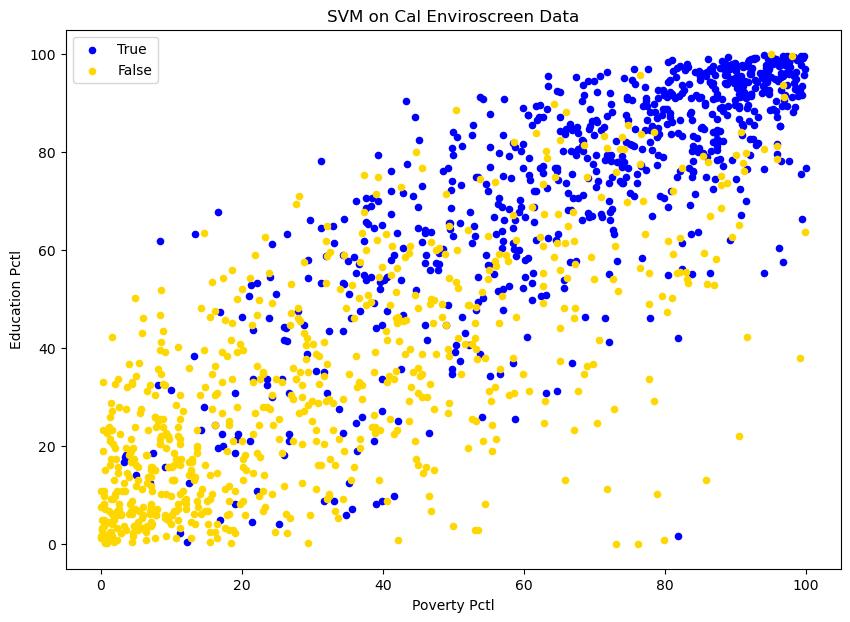

In [20]:
# run this cell
plt.figure(figsize = (10,7))

classes = y['Pollution Burden Pctl'].unique()
y_label = np.array([np.where(classes == i)[0][0] for i in y.values])

labels = [None]*len(y_label)
for i in classes:
    labels[np.where(y == i)[0][0]] = i

for i in range(len(X)):
    plt.scatter(X.iloc[i, 0], X.iloc[i, 1], c=colormap[y_label[i]], s=20, label = labels[i])

plt.xlabel("Poverty Pctl")
plt.ylabel("Education Pctl")
plt.title("SVM on Cal Enviroscreen Data")

plt.legend();

**Question 3.2 (2pts)** Based on the scatter plot, does a SVM classifier using these two variables seem like a good choice for predicting whether a tract will fall into the highest or lowest score bracket? Why or why not? Which type of SVM kernel (linear, quadratic, radial) would be most appropriate for this problem?

*YOUR ANSWER HERE*

*SOLUTION* *An SVM classifier seems like a plausible choice: our response variable is not very distinctly separated into two regions of our feature space, but the majority of points are separated. A linear kernel would be appropriate because the bulk of the data are separated along a line that passes from the upper left to the lower right of our feature space. A quadratic kernel could also work, but a radial kernel probably isn't the best choice for this problem.*

**Question 3.3 (1pt):** Let's try it. Split `X` and `y` into train and test sets, using an 70/30 train/test split and a `random_state` of 2022.

In [27]:
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(...)  

TypeError: Singleton array array(Ellipsis, dtype=object) cannot be considered a valid collection.

In [21]:
# SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 2022)  

**Question 3.4 (1pt):** Let's start classifying information now. Below, instantiate a `SVC` with a linear kernel and fit the model using the training data. Start with a `C` of 1.

*Hint: If you get the error,* 

>`DataConversionWarning`: A column-vector ?? was passed when a `1d` array was expected. Please change the shape of ?? to (n_samples, ), for example using `ravel()`

*use y_train.values.ravel() to override this issue*

In [22]:
svclassifier = ....
svclassifier.fit(...)

SyntaxError: invalid syntax (2823254098.py, line 1)

In [23]:
# SOLUTION
svclassifier = SVC(kernel='linear', C=1)  
svclassifier.fit(X_train, y_train.values.ravel()) 

SVC(C=1, kernel='linear')

**Question 3.5 (1pt):** Use the classifier to predict the outcome of our `X_test` and save the output to `y_pred`.

In [24]:
# YOUR CODE HERE
y_pred = svclassifier.predict(...)

/srv/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


TypeError: float() argument must be a string or a number, not 'ellipsis'

In [25]:
# SOLUTION
y_pred = svclassifier.predict(X_test)  

Let's see how our model performs. Run the box below to create a confusion matrix to score the model.

In [26]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  

[[170  47]
 [ 37 185]]


**Question 3.6 (2pts)** Interpret the values in the confusion matrix. What does each of the four values mean? The [documentation for `confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) is a good reference.

*Your answer here*
* Top left:
* Top right:
* Lower left: 
* Lower right:

**Solution:** 
* *Top left: the number of samples that were actually in the "1-5% (lowest scores)" class that were correctly classified.*
* *Top right: the number of samples actually in the "1-5% (lowest scores)" class that were incorrectly classified as "95-100% (highest scores)".*
* *Lower left: the number of samples actually in the "95-100% (highest scores)" class that were incorrectly classifed as "1-5% (lowest scores)".*
* *Lower right: the number of samples actually in the "95-100% (highest scores)" class that were correctly classified.*

Run the following cell to see a classification report.

In [27]:
print(classification_report(y_test,y_pred))  

              precision    recall  f1-score   support

       False       0.82      0.78      0.80       217
        True       0.80      0.83      0.81       222

    accuracy                           0.81       439
   macro avg       0.81      0.81      0.81       439
weighted avg       0.81      0.81      0.81       439



**Question 3.7 (1pt)** Distinguish between precision and recall in the classification report. Which value would help you determine the number of false positives for the "highest score" class? Which value would help you determine the number of false negatives?

For reference, see the documentation for [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html); scrolling down to the "Returns" section and following relevant links there will also be helpful.

*Your answer here*

**Answer**: *The precision ratio contains false positives in the denominator, while the recall ratio contains false negatives.*

Run the cell below to see what our classification looks like! 

/srv/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


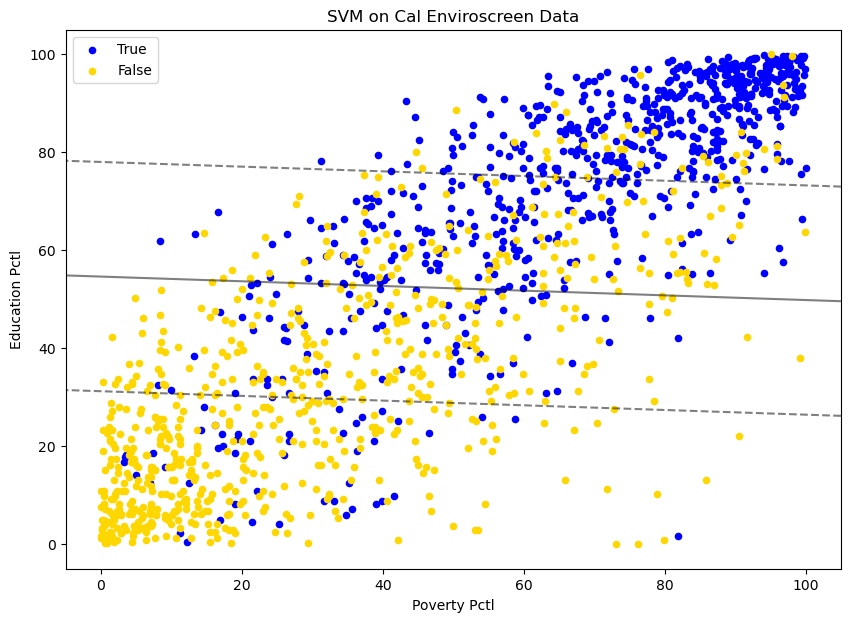

In [28]:
# run this cell
plt.figure(figsize = (10,7))

classes = y['Pollution Burden Pctl'].unique()
y_label = np.array([np.where(classes == i)[0][0] for i in y.values])

labels = [None]*len(y_label)
for i in classes:
    labels[np.where(y == i)[0][0]] = i

for i in range(len(X)):
    plt.scatter(X.iloc[i, 0], X.iloc[i, 1], c=colormap[y_label[i]], s=20, label = labels[i])

plot_svc_decision_function(svclassifier)

plt.xlabel("Poverty Pctl")
plt.ylabel("Education Pctl")
plt.title("SVM on Cal Enviroscreen Data")

plt.legend();

**Question 3.8 (3pts)** Fit two new models: one using `C`=0.01 and one using `C`=100. Print the classification matrix for each. Which model performs the best? Based on this, do you think your original model with `C`=1 has high bias or high variance?

In [ ]:
# YOUR CODE HERE

*YOUR ANSWER HERE*

In [34]:
# SOLUTION (C=1 is also included here for ease of comparison)
c_values = [0.01,1,100]
for c in c_values:
    model = SVC(kernel='linear', C=c)  
    model.fit(X_train, y_train.values.ravel()) 
    y_pred = model.predict(X_test)
    print('C = {}'.format(c))
    print(confusion_matrix(y_test,y_pred))  

C = 0.01
[[171  46]
 [ 37 185]]
C = 1
[[170  47]
 [ 37 185]]
C = 100
[[170  47]
 [ 37 185]]


*SOLUTION* *Of the three, the model with C=0.01 performs slightly better because it has one fewer misclassification than C=1, and has 10 fewer than C=1000. Because the scikit-learn parameter is inversely proportional to the hyperparameter* ***C*** *as we learned it in lecture, we are achieving better performance with a more "lenient" model. Thus our original model with C=1 was probably overfit (high variance).*

**Question 3.9** (3pts) Now run the two other SVMs we have added below -- one with a polynomial kernel, and one with a radial basis function kernel. Both can use scikit-learn's default values for $d$ or $\gamma$.  Compare these to the best linear model from above.  Keep $C$ equal to your best value from the last problem -- but know that you should tune $C$, the polynomial degree and $\gamma$ by cross validation.  

Report the performance of the models using their confusion matrices, precision and recall.  Any policy intervention would be used to improve the highest impacted communities.  Therefore focus on which model performs best on the TRUE class.  Between linear, polynomial and rbf kernels, which do you like best?  

In [31]:
kernel_choices = ['linear', 'poly', 'rbf']
c = 0.01
for knl in kernel_choices:
    model = SVC(kernel=knl, C=c)  
    model.fit(X_train, y_train.values.ravel()) 
    y_pred = model.predict(X_test)
    print('Kernel = {}'.format(knl))
    print(confusion_matrix(y_test,y_pred))  
    print(classification_report(y_test,y_pred)) 

Kernel = linear
[[171  46]
 [ 37 185]]
              precision    recall  f1-score   support

       False       0.82      0.79      0.80       217
        True       0.80      0.83      0.82       222

    accuracy                           0.81       439
   macro avg       0.81      0.81      0.81       439
weighted avg       0.81      0.81      0.81       439

Kernel = poly
[[196  21]
 [ 57 165]]
              precision    recall  f1-score   support

       False       0.77      0.90      0.83       217
        True       0.89      0.74      0.81       222

    accuracy                           0.82       439
   macro avg       0.83      0.82      0.82       439
weighted avg       0.83      0.82      0.82       439

Kernel = rbf
[[169  48]
 [ 40 182]]
              precision    recall  f1-score   support

       False       0.81      0.78      0.79       217
        True       0.79      0.82      0.81       222

    accuracy                           0.80       439
   macro avg    

*SOLUTION: (Note there is no truly correct answer here -- any answer that reasonably examines the problem from a few angles will get full points.)  *

*The polynomial kernel has a better precision on the TRUE class, meaning the communities it identifies as TRUE are actually TRUE more often than other models.  But the linear kernel has the highest recall on the TRUE class, meaning it finds more of the impacted communities than any other model, at the expense of some precision.  The rbf does not seem to perform better on any counts.*

*In other words, the polynomial kernel is a little more conservative in identifying positive classes:  You can be more sure you're right with TRUE classifications, but you also know you're not identifying every TRUE class possible.  On the other hand, the linear kernel is less likely to miss communities that are actually impacted.*

*Based on this reasoning, it's best to choose the linear kernel: If resources are allocated according to which communiites are categorized as TRUE, it's better not to miss communities that need help.*

**Example best practice for cross validation**.  Before you finish, have a look at the code below.  It may throw errors if you haven't done everything above correctly, but you can still use this as a basis for any future work where you're tuning model hyperparameters by cross validation.  

Note that we can actually choose the best model based on its recall (by default, for the positive class).  

We'll comment a little on the output in the markdown cell after.

In [30]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':['linear', 'rbf', 'poly'], 'C':[0.01, 1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring = 'recall', cv = 5) # here we are setting up a model cross validation object.
clf.fit(X_train, y_train.values.ravel()) # now we fit on all combinations of parameters. 
clf.best_estimator_

SVC(C=1, kernel='linear')

The output says that linear kernel with C=1 is your best bet.  That's different from what we saw above.  Why?  Because we're evaluating performance by cross validation rather than against the withheld test data set, and because we're choosing the best model based on recall.

---
## Submission

Congrats, you finished the final homework!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.html** and submit the file through bCourses.

---

## Bibliography

Carnegie Mellon University's Machine Learning Course (10 - 701) - Images on Question 2 - http://www.cs.cmu.edu/~ninamf/courses/601sp15/lectures.shtml

Jayanta Basak, *A Least Square Kernel Machine with Box Constraints* - Inspiration and Formula for Question 4.4 - http://www.jprr.org/index.php/jprr/article/viewfile/181/57

Jake VanderPlas - Function for Drawing SVC Decision Boundaries - *Python Data Science Handbook*

---
Notebook developed by: Beom Jin Lee (Brian)

Data Science Modules: http://data.berkeley.edu/education/modules
